In [2]:
import yfinance as yf
import pandas as pd
import numpy as np


ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-12-31'


data = yf.download(ticker, start=start_date, end=end_date)


print(data.head())

C:\Users\nikhi\AppData\Local\Temp\ipykernel_24644\2360461500.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.538521  72.598899  71.292311  71.545897  135480400
2020-01-03  71.833305  72.594071  71.608700  71.765682  146322800
2020-01-06  72.405678  72.444321  70.703012  70.954188  118387200
2020-01-07  72.065147  72.671341  71.845369  72.415337  108872000
2020-01-08  73.224411  73.526303  71.768086  71.768086  132079200


In [3]:
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

print(f"Shape after feature creation: {data.shape}")

Shape after feature creation: (1257, 8)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA50', 'MA200', 'RSI']
target = 'Next_Close'

data[target] = data['Close'].shift(-1)

print(f"Shape after creating target variable: {data.shape}")

data = data.dropna()

print(f"Shape after dropping all NaNs: {data.shape}")

if data.empty:
    raise ValueError("The DataFrame is empty after cleaning. "
                     "Try extending your start_date to fetch more historical data.")

X = data[features]
y = data[target]

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Shape after creating target variable: (1257, 9)
Shape after dropping all NaNs: (1057, 9)
Training set shape: (845, 8)
Test set shape: (212, 8)


Root Mean Squared Error (RMSE): $30.62


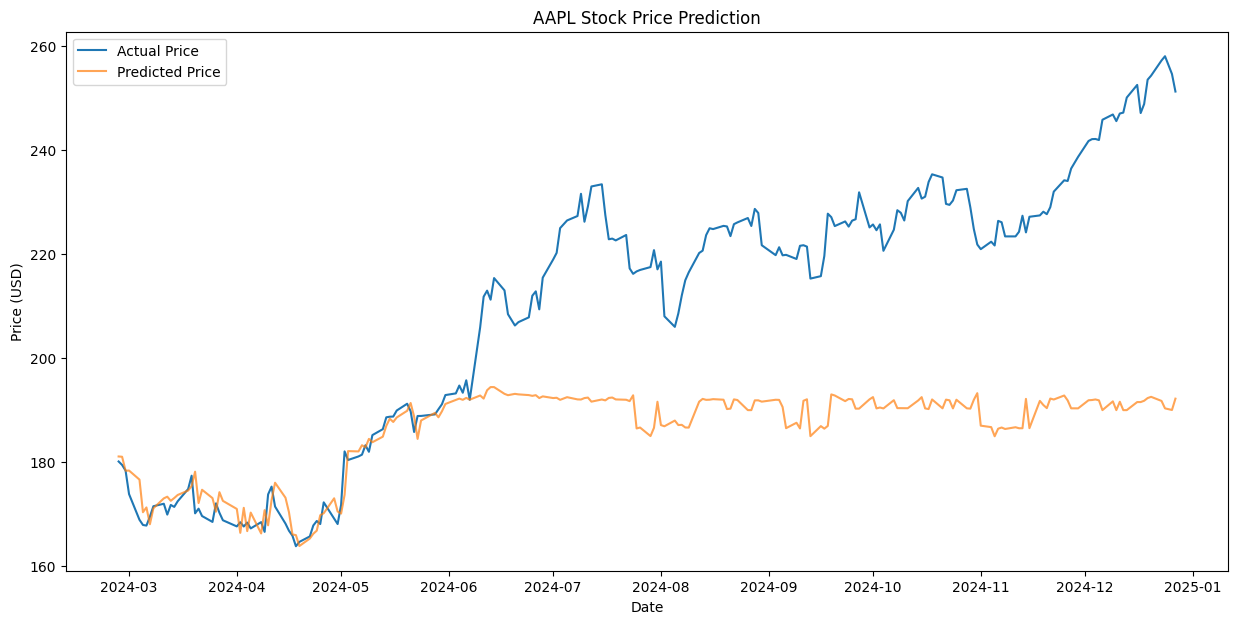

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=1000, 
                         learning_rate=0.05,
                         early_stopping_rounds=50, 
                         n_jobs=-1)

model.fit(X_train_scaled, y_train, 
          eval_set=[(X_test_scaled, y_test)], 
          verbose=False)

predictions = model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
 
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, predictions, label='Predicted Price', alpha=0.7)
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [6]:
import joblib

joblib.dump(model, "stock_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler have been saved successfully.")

Model and scaler have been saved successfully.
